# Kelompok Squash Delight

Anggota kelompok:
1. Azrian Rifqi Radhitya (1301223292)
2. Muhammad Bagas Wahyudi (1301220296)

# Dataset Description

The fruit classification dataset is a collection of images of various fruits used for the purpose of the training and testing computer vision models downloaded from [Kaggle](https://www.kaggle.com/datasets/utkarshsaxenadn/fruits-classification). The dataset includes five different types of fruit:

- Apples
- Bananas
- Grapes
- Mangoes
- Strawberries

Each class contains 2000 images, resulting in a total of 10,000 images in the dataset.

The images in the dataset are of various shapes, sizes, and colors, and have been captured under different lighting conditions. The dataset is useful for training and testing models that perform tasks such as object detection, image classification, and segmentation.

The dataset can be used for various research projects, such as developing and testing new image classification algorithms, and for benchmarking existing algorithms. The dataset can also be used to train machine learning models that can be used in real-world applications, such as in the agricultural industry for fruit grading and sorting.

# Import Library

In [1]:
# system and utils
import os
import random
import shutil

# Visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image

# OpenCV and image augmentation
import cv2
from skimage.transform import rotate
from skimage.exposure import adjust_gamma

# TensorFlow
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.callbacks import History

# Pretrained models
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0, ResNet50

2025-12-01 09:51:25.916538: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764582686.089306      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764582686.134282      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Data Preparation

## Data Loading

In [2]:
!ls /kaggle/input

fruits-classification


In [3]:
src = "/kaggle/input/fruits-classification/Fruits Classification"
dst = "/kaggle/working/Fruits Classification"
os.makedirs(dst, exist_ok=True)

# Pindahkan semua file
shutil.copytree(src, dst, dirs_exist_ok=True)
print("Files copied to working directory!")

dataset_path = "/kaggle/working/Fruits Classification"
train_dir = os.path.join(dataset_path, "train")
val_dir = os.path.join(dataset_path, "valid")
test_dir = os.path.join(dataset_path, "test")

print("Dataset Path:", dataset_path)
print("Train Folder:", train_dir)
print("Validation Folder:", val_dir)
print("Test Folder:", test_dir)

Files copied to working directory!
Dataset Path: /kaggle/working/Fruits Classification
Train Folder: /kaggle/working/Fruits Classification/train
Validation Folder: /kaggle/working/Fruits Classification/valid
Test Folder: /kaggle/working/Fruits Classification/test


## Class Distribution

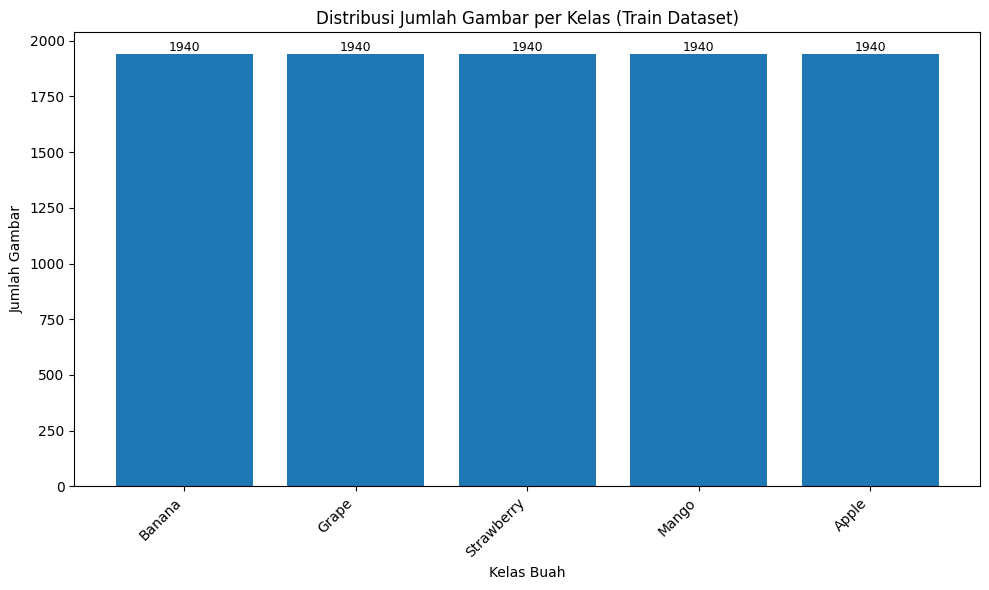

In [4]:
class_counts = {}
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        num_images = len([
            f for f in os.listdir(class_path)
            if f.lower().endswith(('.png', '.jpg', '.jpeg'))
        ])
        class_counts[class_name] = num_images

df = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Count']).sort_values('Count', ascending=False)

plt.figure(figsize=(10,6))
bars = plt.bar(df['Class'], df['Count'])
plt.xticks(rotation=45, ha='right')
plt.title("Distribusi Jumlah Gambar per Kelas (Train Dataset)")
plt.xlabel("Kelas Buah")
plt.ylabel("Jumlah Gambar")


for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1,
             str(height), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## Plot 5 Random Photos for Each Classes

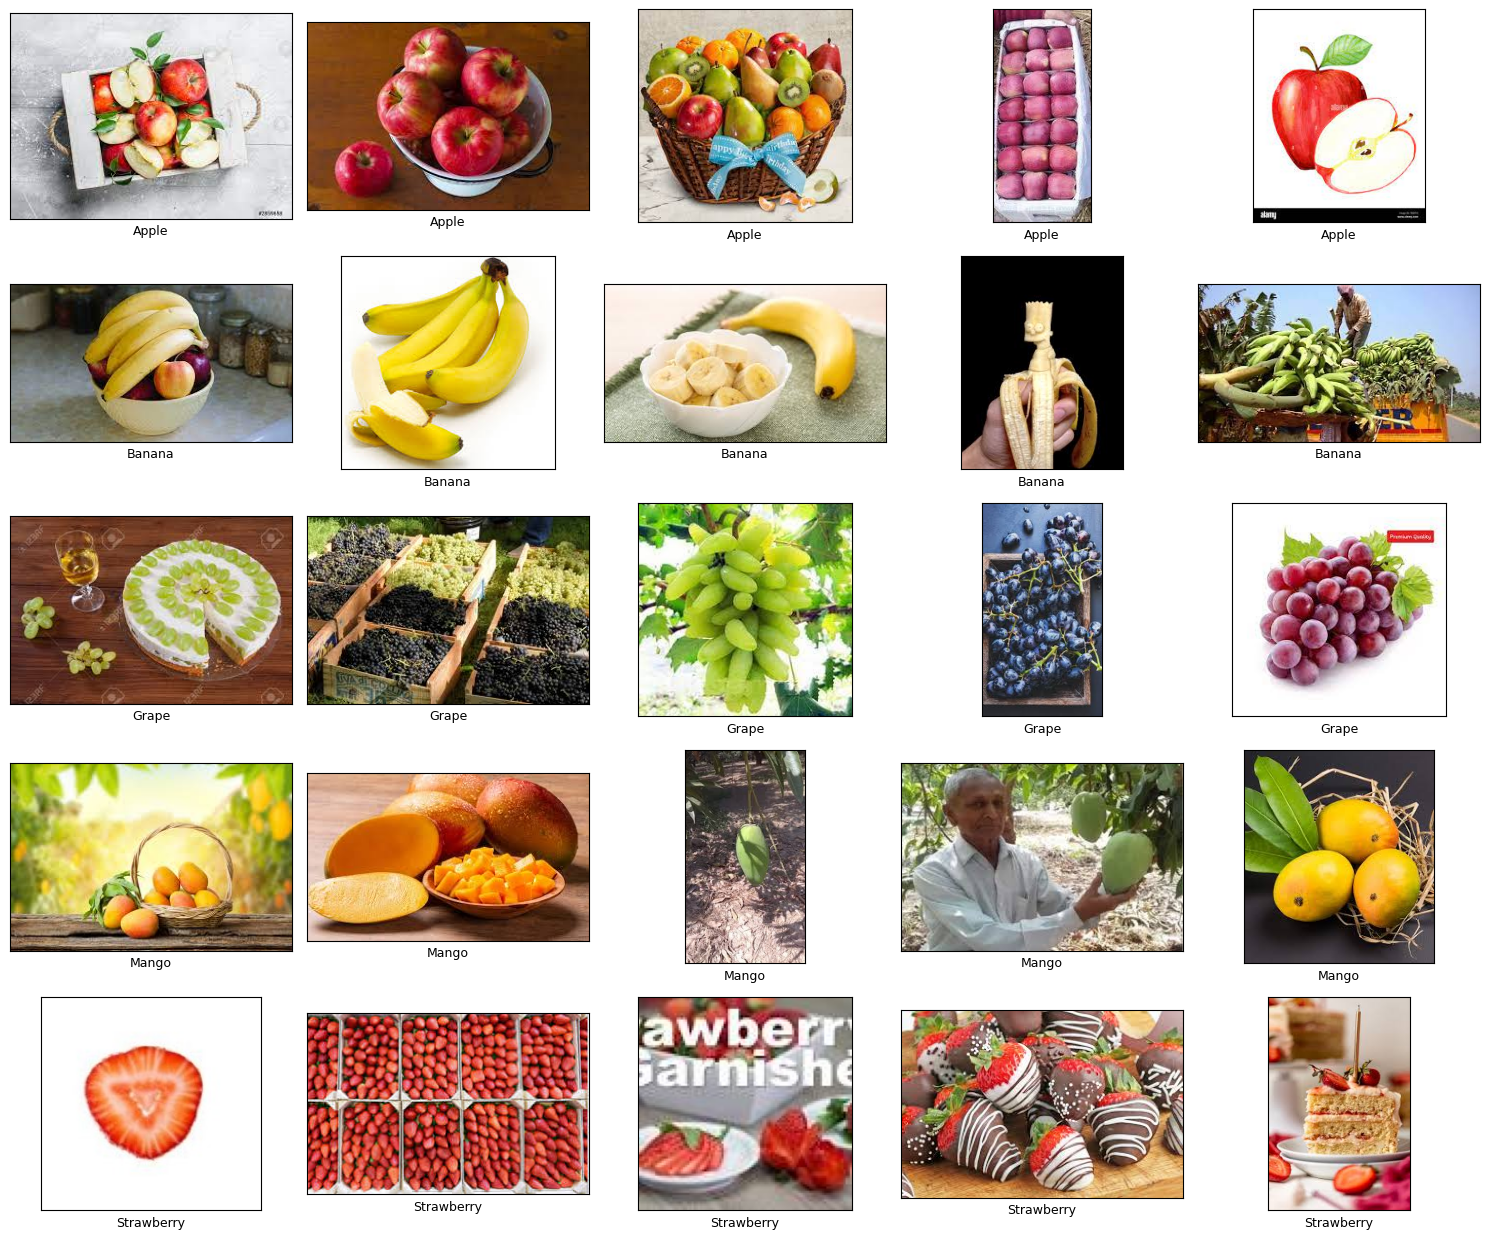

In [5]:
path_sub = train_dir
fruits_image = {}
for class_name in sorted(os.listdir(path_sub)):
    class_path = os.path.join(path_sub, class_name)
    if os.path.isdir(class_path):
        fruits_image[class_name] = [
            f for f in os.listdir(class_path)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ]

num_images = 5
fig, axs = plt.subplots(len(fruits_image), num_images, figsize=(15, len(fruits_image) * 2.5))

for i, class_name in enumerate(sorted(fruits_image.keys())):
    images = np.random.choice(fruits_image[class_name], num_images, replace=False)
    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        with Image.open(img_path) as img:
            axs[i, j].imshow(img)
        axs[i, j].set_xlabel(class_name, fontsize=9)  # class label
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])

fig.tight_layout()
plt.show()


# Data Preprocessing

## Data Augmentation

In [6]:
aug_dir = os.path.join(dataset_path, 'train_augmented')
os.makedirs(aug_dir, exist_ok=True)

target_aug_per_class = 750

def random_rotation(img):
    return rotate(cv2.resize(img,(224,224)), random.randint(-20,20), preserve_range=True).astype(np.uint8)

def horizontal_flip(img):
    return cv2.flip(cv2.resize(img,(224,224)), 1)

def random_brightness(img):
    factor = random.uniform(0.8, 1.2)
    return np.clip(cv2.resize(img,(224,224)) * factor, 0, 255).astype(np.uint8)

def random_blur(img):
    return cv2.GaussianBlur(cv2.resize(img,(224,224)), (3,3), 0)

def random_shift(img):
    tx, ty = random.randint(-10,10), random.randint(-10,10)
    M = np.float32([[1,0,tx],[0,1,ty]])
    return cv2.warpAffine(cv2.resize(img,(224,224)), M, (224,224))
    
augmentations = [
    random_rotation,
    horizontal_flip,
    random_brightness,
    random_blur,
    random_shift
]


for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    save_class_dir = os.path.join(aug_dir, class_name)
    os.makedirs(save_class_dir, exist_ok=True)

    images = os.listdir(class_path)
    for i in range(target_aug_per_class):
        img_name = random.choice(images)
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)

        # Choose random function
        aug_func = random.choice(augmentations)
        aug_img = aug_func(img)

        save_path = os.path.join(save_class_dir, f'aug_{i}_{img_name}')
        cv2.imwrite(save_path, aug_img)

# Merge with train directory
for class_name in os.listdir(aug_dir):
    src_class_dir = os.path.join(aug_dir, class_name)
    dst_class_dir = os.path.join(train_dir, class_name)
    os.makedirs(dst_class_dir, exist_ok=True)
    for img_name in os.listdir(src_class_dir):
        shutil.copy(os.path.join(src_class_dir, img_name),
                    os.path.join(dst_class_dir, img_name))

print("Augmentasi modular selesai dan digabung ke train_dir!")

for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    count = len(os.listdir(class_path))
    print(f"Kelas {class_name}: {count} gambar")

Augmentasi modular selesai dan digabung ke train_dir!
Kelas Banana: 2690 gambar
Kelas Grape: 2690 gambar
Kelas Strawberry: 2690 gambar
Kelas Mango: 2690 gambar
Kelas Apple: 2690 gambar


## Plot Augmented Image

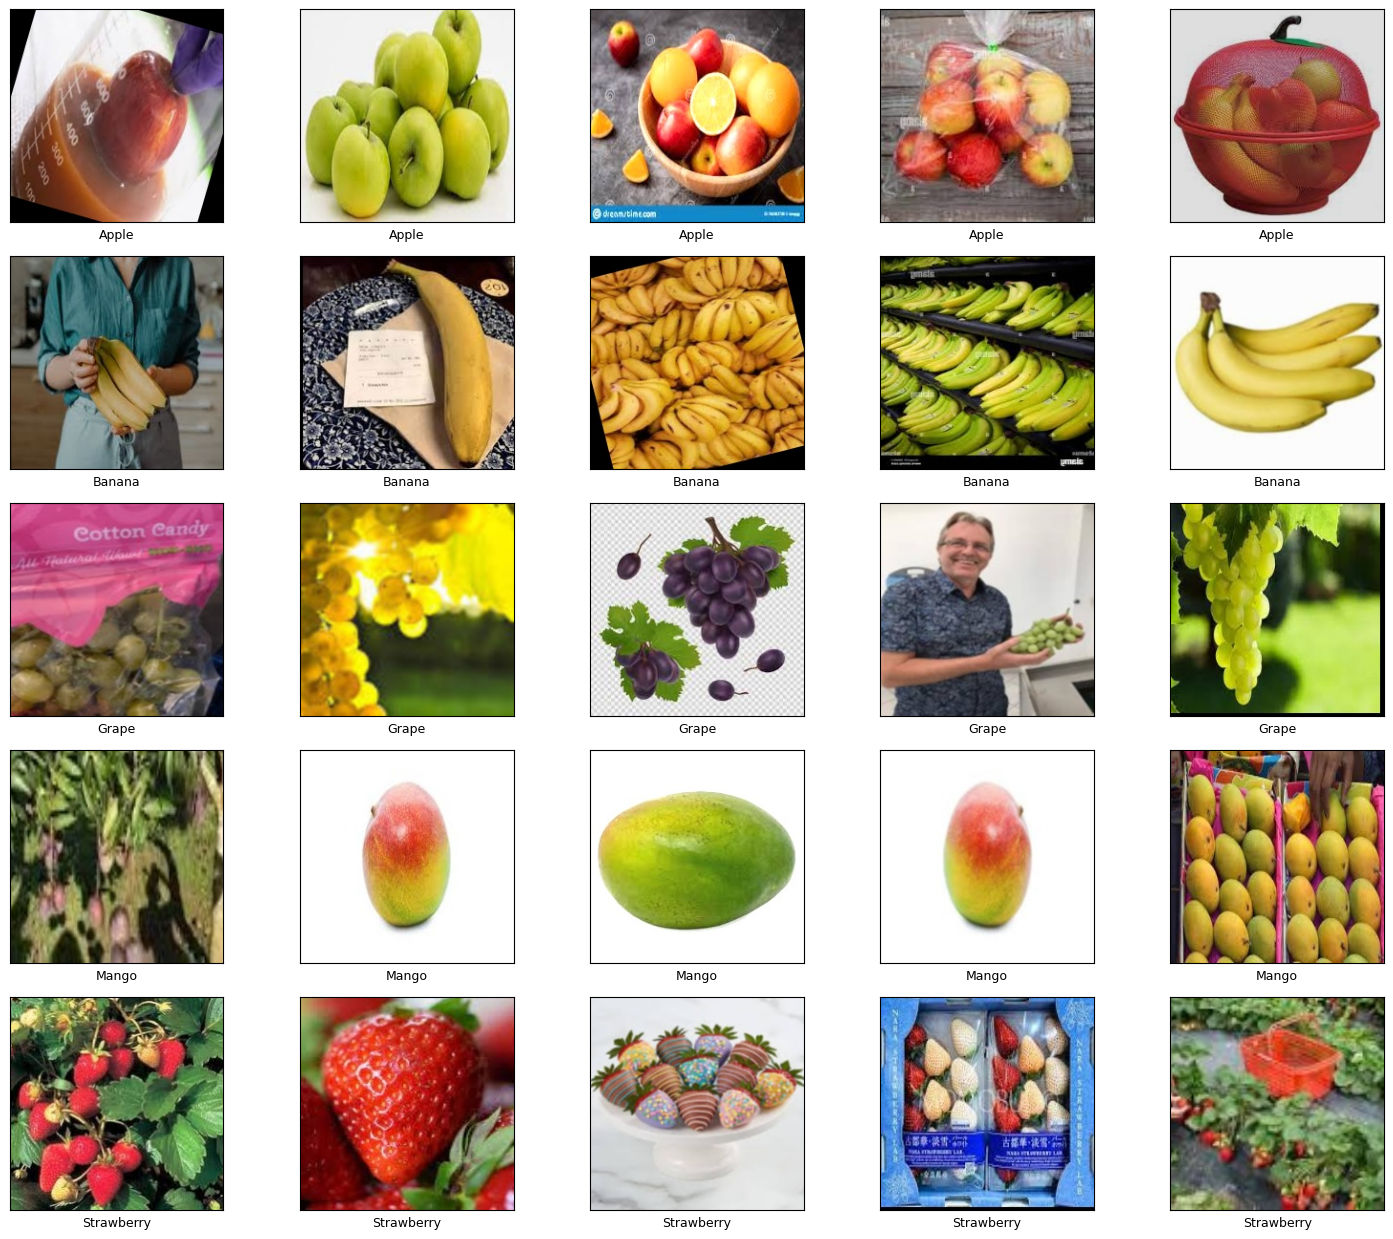

In [7]:
path_sub = aug_dir
fruits_image = {}
for class_name in sorted(os.listdir(path_sub)):
    class_path = os.path.join(path_sub, class_name)
    if os.path.isdir(class_path):
        fruits_image[class_name] = [
            f for f in os.listdir(class_path)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ]

num_images = 5
fig, axs = plt.subplots(len(fruits_image), num_images, figsize=(15, len(fruits_image) * 2.5))

for i, class_name in enumerate(sorted(fruits_image.keys())):
    images = np.random.choice(fruits_image[class_name], num_images, replace=False)
    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        with Image.open(img_path) as img:
            axs[i, j].imshow(img)
        axs[i, j].set_xlabel(class_name, fontsize=9)  # class label
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])

fig.tight_layout()
plt.show()


## Preprocessing for Each Model

In [8]:
IMG_SIZE   = (224, 224)
BATCH_SIZE = 32
AUTOTUNE   = tf.data.AUTOTUNE

num_classes = 5  

# 1) MobileNetV2: input float32, piksel dinormalisasi ke [-1, 1]
#    [0..255] -> [0..1] -> [-1..1]
def preprocess_mobilenet_manual(x):
    x = tf.cast(x, tf.float32)
    x = x / 127.5 - 1.0
    return x

# 2) ResNet50: RGB -> BGR + kurangi mean per channel (ImageNet)
IMAGENET_MEAN = tf.constant([103.939, 116.779, 123.68], dtype=tf.float32)

def preprocess_resnet_manual(x):
    x = tf.cast(x, tf.float32)
    # RGB -> BGR
    x = x[..., ::-1]
    # zero-center per channel
    x = x - IMAGENET_MEAN
    return x

# 3) EfficientNetB0:
#    Menurut desain Keras EfficientNet, normalisasi utama (Rescaling 1/255)
#    dilakukan di dalam model. Di luar, kita cukup pastikan float32.
def preprocess_efficientnet_manual(x):
    return tf.cast(x, tf.float32)

I0000 00:00:1764582776.821192      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1764582776.821831      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [9]:
def load_and_preprocess(train_dir, val_dir, test_dir, preprocess_fn):
    """
    Fungsi generik untuk:
    - load dataset
    - apply preprocessing manual
    - cache + prefetch
    """
    def load_ds(dir_path, shuffle):
        ds = tf.keras.utils.image_dataset_from_directory(
            dir_path,
            image_size=IMG_SIZE,
            batch_size=BATCH_SIZE,
            label_mode='int',
            shuffle=shuffle
        )
        return ds.map(
            lambda x, y: (preprocess_fn(x), y),
            num_parallel_calls=AUTOTUNE
        ).cache().prefetch(AUTOTUNE)

    train = load_ds(train_dir, shuffle=True)
    val   = load_ds(val_dir,   shuffle=False)
    test  = load_ds(test_dir,  shuffle=False)

    return train, val, test


# MOBILE-NET
train_mob, val_mob, test_mob = load_and_preprocess(
    train_dir, val_dir, test_dir,
    preprocess_mobilenet_manual
)

# RESNET
train_res, val_res, test_res = load_and_preprocess(
    train_dir, val_dir, test_dir,
    preprocess_resnet_manual
)

# EFFICIENTNET
train_eff, val_eff, test_eff = load_and_preprocess(
    train_dir, val_dir, test_dir,
    preprocess_efficientnet_manual
)

Found 13450 files belonging to 5 classes.
Found 200 files belonging to 5 classes.
Found 100 files belonging to 5 classes.
Found 13450 files belonging to 5 classes.
Found 200 files belonging to 5 classes.
Found 100 files belonging to 5 classes.
Found 13450 files belonging to 5 classes.
Found 200 files belonging to 5 classes.
Found 100 files belonging to 5 classes.


# Modelling

## Skema Modifikasi Model

Pada eksperimen ini, setiap model menggunakan backbone berbeda (ResNet, MobileNetV2, EfficientNet, dll.) tetapi **classifier head dibuat sama** sehingga perbandingan performa lebih fokus pada kualitas backbone.


### 1. Arsitektur Model

Setiap model menggunakan struktur berikut:

```python
model = Sequential([
    Input(shape=(224, 224, 3)),
    backbone,                     # pretrained ImageNet
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])
```

### 2. Skema 1 — Training dengan Backbone di-Freeze (Baseline / Feature Extraction)
Sebelum mencoba fine-tuning, dilakukan training freeze-all sebagai baseline (tanpa fine tuning sama sekali).

- Semua layer backbone di-freeze.
- Hanya classifier head yang dilatih.

Tujuan:

- Menggunakan backbone sebagai feature extractor murni.
- Mendapatkan baseline awal untuk setiap arsitektur.
- Menstabilkan proses training sebelum masuk ke fine-tuning.
- Mengamati gap antara train accuracy dan validation accuracy untuk mendeteksi overfitting/underfitting.

Hasil dari tahap ini digunakan sebagai acuan sebelum melanjutkan ke fine-tuning.

### 3. Skema 2 — Fine-Tuning (Unfreeze Sebagian Backbone)
Sebelum fine-tuning, model dilatih dulu dengan freeze-all agar classifier head yang masih baru bisa beradaptasi dengan fitur backbone tanpa mengubah bobot pretrained. Jika fine-tuning dilakukan langsung, backbone bisa berubah terlalu cepat dan membuat training tidak stabil. Dengan freeze-all dulu, model menjadi lebih stabil dan siap untuk fine-tuning yang lebih halus dan efektif.

- Unfreeze sebagian kecil layer (10% hingga 50% dengan kelipatan 10%).
- Menggunakan learning rate rendah.
- Dievaluasi berdasarkan perubahan akurasi dan loss (train/validation) pada grafik.


## Callbacks

In [10]:
checkpoint_efficient = "models/best_model_efficient.keras"
checkpoint_mobilenet = "models/best_model_mobilenet.keras"
checkpoint_resnet = "models/best_model_resnet.keras"

callbacks_efficientnet = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint(filepath=checkpoint_efficient, monitor='val_loss', save_best_only=True, verbose=1)
]

callbacks_mobilenet = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint(filepath=checkpoint_mobilenet, monitor='val_loss', save_best_only=True, verbose=1)
]

callbacks_resnet = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint(filepath=checkpoint_resnet, monitor='val_loss', save_best_only=True, verbose=1)
]

num_classes = 5

## MobileNetV2

In [11]:
base_mobilenet = MobileNetV2(include_top=False)
base_mobilenet.trainable = False

model_mobilenet = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    base_mobilenet,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),  
    layers.Dropout(0.5),     
    layers.Dense(num_classes, activation='softmax')
])
model_mobilenet.summary()

/tmp/ipykernel_20/2142313715.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_mobilenet = MobileNetV2(include_top=False)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,597 (9.24 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [12]:
# ==== STAGE 1: Feature Extraction (backbone dibekukan) ====

base_mobilenet.trainable = False

model_mobilenet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

initial_epochs_stage1 = 10  

history_mobilenet_stage1 = model_mobilenet.fit(
    train_mob,
    validation_data=val_mob,
    epochs=initial_epochs_stage1,
    verbose=1,
    callbacks=callbacks_mobilenet
)

# ==== STAGE 2: Fine-tuning (unfreeze sebagian layer atas) ====

base_mobilenet.trainable = True
for layer in base_mobilenet.layers[:int(0.8 * len(base_mobilenet.layers))]:
    layer.trainable = False

model_mobilenet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

completed_epochs = len(history_mobilenet_stage1.epoch)
fine_tune_epochs = 20  
total_epochs = completed_epochs + fine_tune_epochs

history_mobilenet_stage2 = model_mobilenet.fit(
    train_mob,
    validation_data=val_mob,
    initial_epoch=completed_epochs,  
    epochs=total_epochs,             
    verbose=1,
    callbacks=callbacks_mobilenet
)

Epoch 1/10


I0000 00:00:1764582789.532791      68 service.cc:148] XLA service 0x781960097f80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764582789.533613      68 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1764582789.533636      68 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1764582790.457882      68 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/421 ━━━━━━━━━━━━━━━━━━━━ 1:21:32 12s/step - accuracy: 0.2500 - loss: 2.0677

I0000 00:00:1764582794.992596      68 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7429 - loss: 0.7053
Epoch 1: val_loss improved from inf to 0.32879, saving model to models/best_model_mobilenet.keras
421/421 ━━━━━━━━━━━━━━━━━━━━ 37s 61ms/step - accuracy: 0.7430 - loss: 0.7049 - val_accuracy: 0.8950 - val_loss: 0.3288
Epoch 2/10
420/421 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8731 - loss: 0.3581
Epoch 2: val_loss improved from 0.32879 to 0.29277, saving model to models/best_model_mobilenet.keras
421/421 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.8732 - loss: 0.3580 - val_accuracy: 0.9050 - val_loss: 0.2928
Epoch 3/10
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8959 - loss: 0.2882
Epoch 3: val_loss improved from 0.29277 to 0.29164, saving model to models/best_model_mobilenet.keras
421/421 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.8959 - loss: 0.2882 - val_accuracy: 0.8950 - val_loss: 0.2916
Epoch 4/10
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9136 - loss: 0.2450
Epoc

## EfficientNetB0

In [13]:
base_efficient = EfficientNetB0(include_top=False)
base_efficient.trainable = False

model_efficient = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    base_efficient,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  
    layers.Dense(num_classes, activation='softmax')
])
model_efficient.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,214,184 (16.08 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [14]:
# ==== STAGE 1: Feature Extraction (backbone dibekukan) ====

base_efficient.trainable = False

model_efficient.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

initial_epochs_stage1 = 10  

history_efficient_stage1 = model_efficient.fit(
    train_eff,
    validation_data=val_eff,
    epochs=initial_epochs_stage1,
    verbose=1,
    callbacks=callbacks_efficientnet
)

# ==== STAGE 2: Fine-tuning (unfreeze sebagian layer atas) ====

base_efficient.trainable = True
for layer in base_efficient.layers[:int(0.8 * len(base_efficient.layers))]:
    layer.trainable = False

model_efficient.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

completed_epochs = len(history_efficient_stage1.epoch)
fine_tune_epochs = 20  
total_epochs = completed_epochs + fine_tune_epochs

history_efficient_stage2 = model_efficient.fit(
    train_eff,
    validation_data=val_eff,
    initial_epoch=completed_epochs,  
    epochs=total_epochs,             
    verbose=1,
    callbacks=callbacks_efficientnet
)

Epoch 1/10
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7973 - loss: 0.5510
Epoch 1: val_loss improved from inf to 0.18652, saving model to models/best_model_efficient.keras
421/421 ━━━━━━━━━━━━━━━━━━━━ 62s 93ms/step - accuracy: 0.7974 - loss: 0.5506 - val_accuracy: 0.9300 - val_loss: 0.1865
Epoch 2/10
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9158 - loss: 0.2417
Epoch 2: val_loss improved from 0.18652 to 0.18253, saving model to models/best_model_efficient.keras
421/421 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - accuracy: 0.9158 - loss: 0.2417 - val_accuracy: 0.9300 - val_loss: 0.1825
Epoch 3/10
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9384 - loss: 0.1773
Epoch 3: val_loss did not improve from 0.18253
421/421 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - accuracy: 0.9384 - loss: 0.1773 - val_accuracy: 0.9400 - val_loss: 0.1835
Epoch 4/10
419/421 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9464 - loss: 0.1475
Epoch 4: val_loss improved from 0.18253 to 0.177

E0000 00:00:1764583310.837743      71 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1764583310.978099      71 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8650 - loss: 0.3791
Epoch 11: val_loss did not improve from 0.14412
421/421 ━━━━━━━━━━━━━━━━━━━━ 75s 96ms/step - accuracy: 0.8650 - loss: 0.3790 - val_accuracy: 0.9300 - val_loss: 0.1770
Epoch 12/30
420/421 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9131 - loss: 0.2479
Epoch 12: val_loss did not improve from 0.14412
421/421 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.9131 - loss: 0.2478 - val_accuracy: 0.9400 - val_loss: 0.1563
Epoch 13/30
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9252 - loss: 0.2154
Epoch 13: val_loss improved from 0.14412 to 0.14412, saving model to models/best_model_efficient.keras
421/421 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - accuracy: 0.9252 - loss: 0.2154 - val_accuracy: 0.9500 - val_loss: 0.1441
Epoch 14/30
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9376 - loss: 0.1828
Epoch 14: val_loss improved from 0.14412 to 0.13686, saving model to models/best_model_efficient.keras
4

## ResNet50

In [15]:
base_resnet = ResNet50(include_top=False)
base_resnet.trainable = False

model_resnet = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    base_resnet,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])
model_resnet.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,629 (90.98 MB)

 Trainable params: 262,917 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [16]:
# ==== STAGE 1: Feature Extraction (backbone dibekukan) ====

base_resnet.trainable = False

model_resnet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

initial_epochs_stage1 = 10  

history_resnet_stage1 = model_resnet.fit(
    train_res,
    validation_data=val_res,
    epochs=initial_epochs_stage1,
    verbose=1,
    callbacks=callbacks_resnet
)

# ==== STAGE 2: Fine-tuning (unfreeze sebagian layer atas) ====
base_resnet.trainable = True

for layer in base_resnet.layers[:int(0.8* len(base_resnet.layers))]:
    layer.trainable = False

model_resnet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

completed_epochs = len(history_resnet_stage1.epoch)
fine_tune_epochs = 20  
total_epochs = completed_epochs + fine_tune_epochs

history_resnet_stage2 = model_resnet.fit(
    train_res,
    validation_data=val_res,
    initial_epoch=completed_epochs,  
    epochs=total_epochs,             
    verbose=1,
    callbacks=callbacks_resnet
)

Epoch 1/10
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.7425 - loss: 0.7452
Epoch 1: val_loss improved from inf to 0.25713, saving model to models/best_model_resnet.keras
421/421 ━━━━━━━━━━━━━━━━━━━━ 72s 135ms/step - accuracy: 0.7427 - loss: 0.7447 - val_accuracy: 0.9050 - val_loss: 0.2571
Epoch 2/10
420/421 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8791 - loss: 0.3266
Epoch 2: val_loss improved from 0.25713 to 0.22420, saving model to models/best_model_resnet.keras
421/421 ━━━━━━━━━━━━━━━━━━━━ 43s 102ms/step - accuracy: 0.8791 - loss: 0.3265 - val_accuracy: 0.9150 - val_loss: 0.2242
Epoch 3/10
420/421 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.9078 - loss: 0.2601
Epoch 3: val_loss improved from 0.22420 to 0.21435, saving model to models/best_model_resnet.keras
421/421 ━━━━━━━━━━━━━━━━━━━━ 44s 105ms/step - accuracy: 0.9079 - loss: 0.2600 - val_accuracy: 0.9200 - val_loss: 0.2143
Epoch 4/10
420/421 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.9208 - loss: 0.22

# Metric Evaluation

In [17]:
def evaluate_model(model, name, test_ds, class_names):
    """
    test_ds     : tf.data.Dataset, berisi batch (images, labels)
    class_names: list of str, urutan nama kelas (sesuai saat buat dataset)
    """

    print(f"\n===== Evaluating {name} =====")

    # --- Evaluasi langsung di test dataset ---
    test_loss, test_acc = model.evaluate(test_ds, verbose=1)
    print(f"{name} - Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

    # --- Kumpulkan y_true dan y_pred dari seluruh batch ---
    y_true = []
    y_pred = []

    for batch_images, batch_labels in test_ds:
        # Prediksi
        preds = model.predict(batch_images, verbose=0)  # shape: (batch_size, num_classes)
        preds_idx = np.argmax(preds, axis=1)

        # Label asli
        labels_np = batch_labels.numpy()
        # Kalau label one-hot, ambil argmax dulu
        if labels_np.ndim > 1:
            labels_np = np.argmax(labels_np, axis=1)

        y_true.append(labels_np)
        y_pred.append(preds_idx)

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    # --- Classification Report ---
    print("\nClassification Report:")
    print(classification_report(
        y_true,
        y_pred,
        target_names=class_names,
        digits=4
    ))

    # --- Confusion Matrix ---
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    return test_acc, test_loss

In [18]:
class_names = sorted([
    d for d in os.listdir(test_dir)
    if os.path.isdir(os.path.join(test_dir, d))
])

print(class_names)

['Apple', 'Banana', 'Grape', 'Mango', 'Strawberry']



===== Evaluating EfficientNetB0 =====
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9531 - loss: 0.1651
EfficientNetB0 - Test Accuracy: 0.9400, Test Loss: 0.1962

Classification Report:
              precision    recall  f1-score   support

       Apple     0.8636    0.9500    0.9048        20
      Banana     0.9091    1.0000    0.9524        20
       Grape     0.9500    0.9500    0.9500        20
       Mango     1.0000    0.9000    0.9474        20
  Strawberry     1.0000    0.9000    0.9474        20

    accuracy                         0.9400       100
   macro avg     0.9445    0.9400    0.9404       100
weighted avg     0.9445    0.9400    0.9404       100



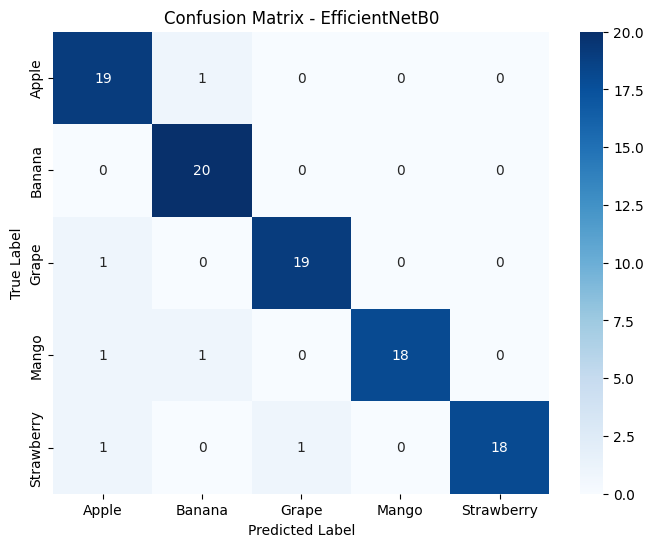


===== Evaluating ResNet50 =====
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 925ms/step - accuracy: 0.9383 - loss: 0.1979
ResNet50 - Test Accuracy: 0.9500, Test Loss: 0.1404

Classification Report:
              precision    recall  f1-score   support

       Apple     1.0000    0.8500    0.9189        20
      Banana     0.9524    1.0000    0.9756        20
       Grape     0.9500    0.9500    0.9500        20
       Mango     0.9048    0.9500    0.9268        20
  Strawberry     0.9524    1.0000    0.9756        20

    accuracy                         0.9500       100
   macro avg     0.9519    0.9500    0.9494       100
weighted avg     0.9519    0.9500    0.9494       100



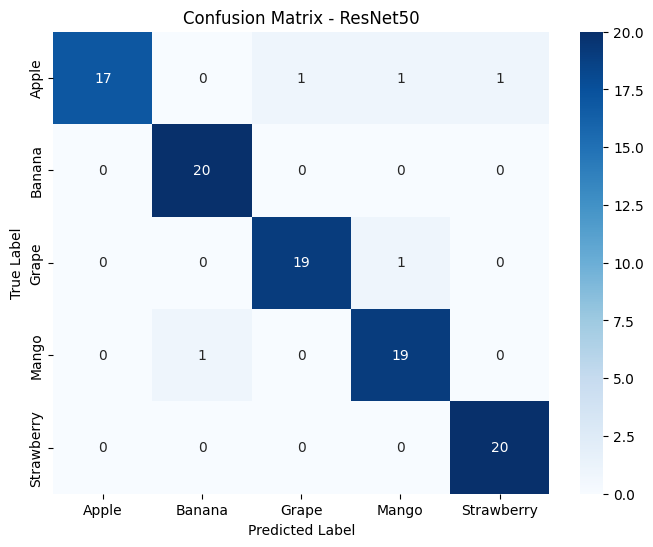


===== Evaluating MobileNetV2 =====
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 738ms/step - accuracy: 0.9376 - loss: 0.1963
MobileNetV2 - Test Accuracy: 0.9300, Test Loss: 0.1977

Classification Report:
              precision    recall  f1-score   support

       Apple     0.8571    0.9000    0.8780        20
      Banana     1.0000    1.0000    1.0000        20
       Grape     0.9500    0.9500    0.9500        20
       Mango     0.9000    0.9000    0.9000        20
  Strawberry     0.9474    0.9000    0.9231        20

    accuracy                         0.9300       100
   macro avg     0.9309    0.9300    0.9302       100
weighted avg     0.9309    0.9300    0.9302       100



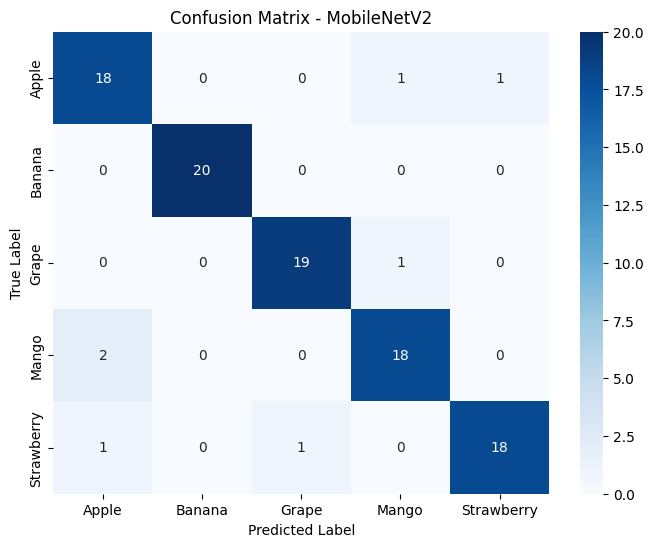

In [19]:
acc_eff, loss_eff = evaluate_model(model_efficient, "EfficientNetB0", test_eff, class_names)
acc_res, loss_res = evaluate_model(model_resnet, "ResNet50", test_res, class_names)
acc_mob, loss_mob = evaluate_model(model_mobilenet, "MobileNetV2", test_mob, class_names)

# Performance Analysis

In [20]:
def analyze_performance(models_list, test_dir, IMG_SIZE=(224, 224)):
    classes = sorted([
        d for d in os.listdir(test_dir)
        if os.path.isdir(os.path.join(test_dir, d))
    ])

    img_paths = []
    for cls in classes:
        cls_dir = os.path.join(test_dir, cls)
        for fname in os.listdir(cls_dir):
            img_paths.append(os.path.join(cls_dir, fname))

    avg_confs = []
    avg_inference_times = []
    avg_prob_dists = []

    for name, model, preprocess_fn in models_list:
        times = []
        max_confs = []
        probs_sum = np.zeros(len(classes), dtype=np.float32)

        for img_path in img_paths:
            img_pil = image.load_img(img_path, target_size=IMG_SIZE)
            img = image.img_to_array(img_pil)
            img_batch = np.expand_dims(img, axis=0)

            batch = preprocess_fn(img_batch.copy())

            start = time.time()
            preds = model.predict(batch, verbose=0)
            inf_time = (time.time() - start) * 1000
            times.append(inf_time)

            probs = preds[0]
            probs_sum += probs

            top_idx = np.argmax(probs)
            top_conf = probs[top_idx] * 100
            max_confs.append(top_conf)

        mean_time = np.mean(times)
        mean_conf = np.mean(max_confs)
        mean_probs = probs_sum / len(img_paths)

        avg_inference_times.append(mean_time)
        avg_confs.append(mean_conf)
        avg_prob_dists.append(mean_probs)

        print(f"{name}: conf rata-rata {mean_conf:.2f}%, waktu rata-rata {mean_time:.2f} ms")

    num_models = len(models_list)
    total_plots = 2 + num_models
    rows = int(np.ceil(total_plots / 3))
    cols = 3

    fig_height = 4 * rows * 1.2
    fig, axes = plt.subplots(rows, cols, figsize=(14, fig_height))
    axes = axes.flatten()

    ax = axes[0]
    ax.bar([m[0] for m in models_list], avg_confs)
    ax.set_title("Rata-rata Confidence (%) per Model")
    ax.set_ylabel("Confidence (%)")
    ax.set_ylim(0, 100)

    ax = axes[1]
    ax.bar([m[0] for m in models_list], avg_inference_times)
    ax.set_title("Rata-rata Waktu Inferensi per Model (ms)")
    ax.set_ylabel("ms")

    for i, (name, _, _) in enumerate(models_list):
        ax = axes[2 + i]
        ax.bar(classes, avg_prob_dists[i])
        ax.set_title(f"Rata-rata Probabilitas - {name}")
        ax.set_ylabel("Probability")
        ax.set_ylim(0, 1)
        ax.tick_params(axis='x', rotation=45)

    for j in range(2 + num_models, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

EfficientNetB0: conf rata-rata 96.67%, waktu rata-rata 113.48 ms
ResNet50: conf rata-rata 97.08%, waktu rata-rata 101.86 ms
MobileNetV2: conf rata-rata 93.02%, waktu rata-rata 91.54 ms


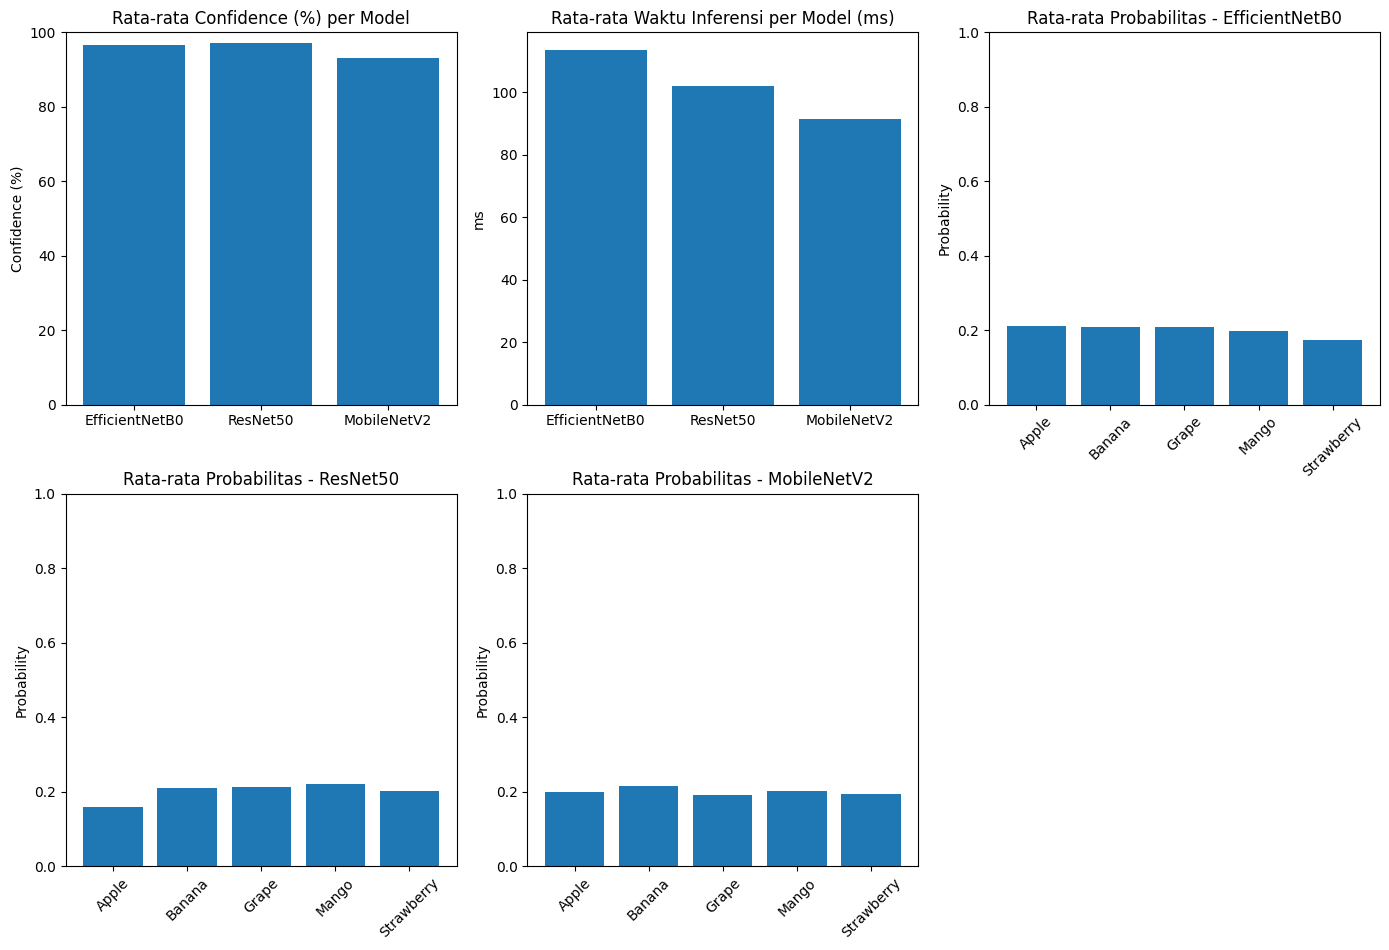

In [21]:
models_list = [
    ("EfficientNetB0", model_efficient, preprocess_efficientnet_manual),
    ("ResNet50",       model_resnet,    preprocess_resnet_manual),
    ("MobileNetV2",    model_mobilenet, preprocess_mobilenet_manual),
]

analyze_performance(
    models_list=models_list,
    test_dir=test_dir,          # folder test yang berisi subfolder per kelas
    IMG_SIZE=IMG_SIZE
)

# Visualization

In [22]:
def combine_histories_object(h1, h2):
    """
    Gabungkan dua objek Keras History menjadi satu objek History.
    h1, h2 = objek History (hasil model.fit)
    """
    
    # Gabungkan dictionary
    combined_dict = {}
    all_keys = set(h1.history.keys()).union(set(h2.history.keys()))
    
    for key in all_keys:
        combined_dict[key] = h1.history.get(key, []) + h2.history.get(key, [])

    # Buat objek History baru
    combined_history = History()
    combined_history.history = combined_dict
    
    # Gabungkan nomor epoch
    combined_history.epoch = list(range(len(list(combined_dict.values())[0])))

    return combined_history

In [23]:
combined_efficient = combine_histories_object(history_efficient_stage1, history_efficient_stage2)
combined_mobilenet = combine_histories_object(history_mobilenet_stage1, history_mobilenet_stage2)
combined_resnet = combine_histories_object(history_resnet_stage1, history_resnet_stage2)

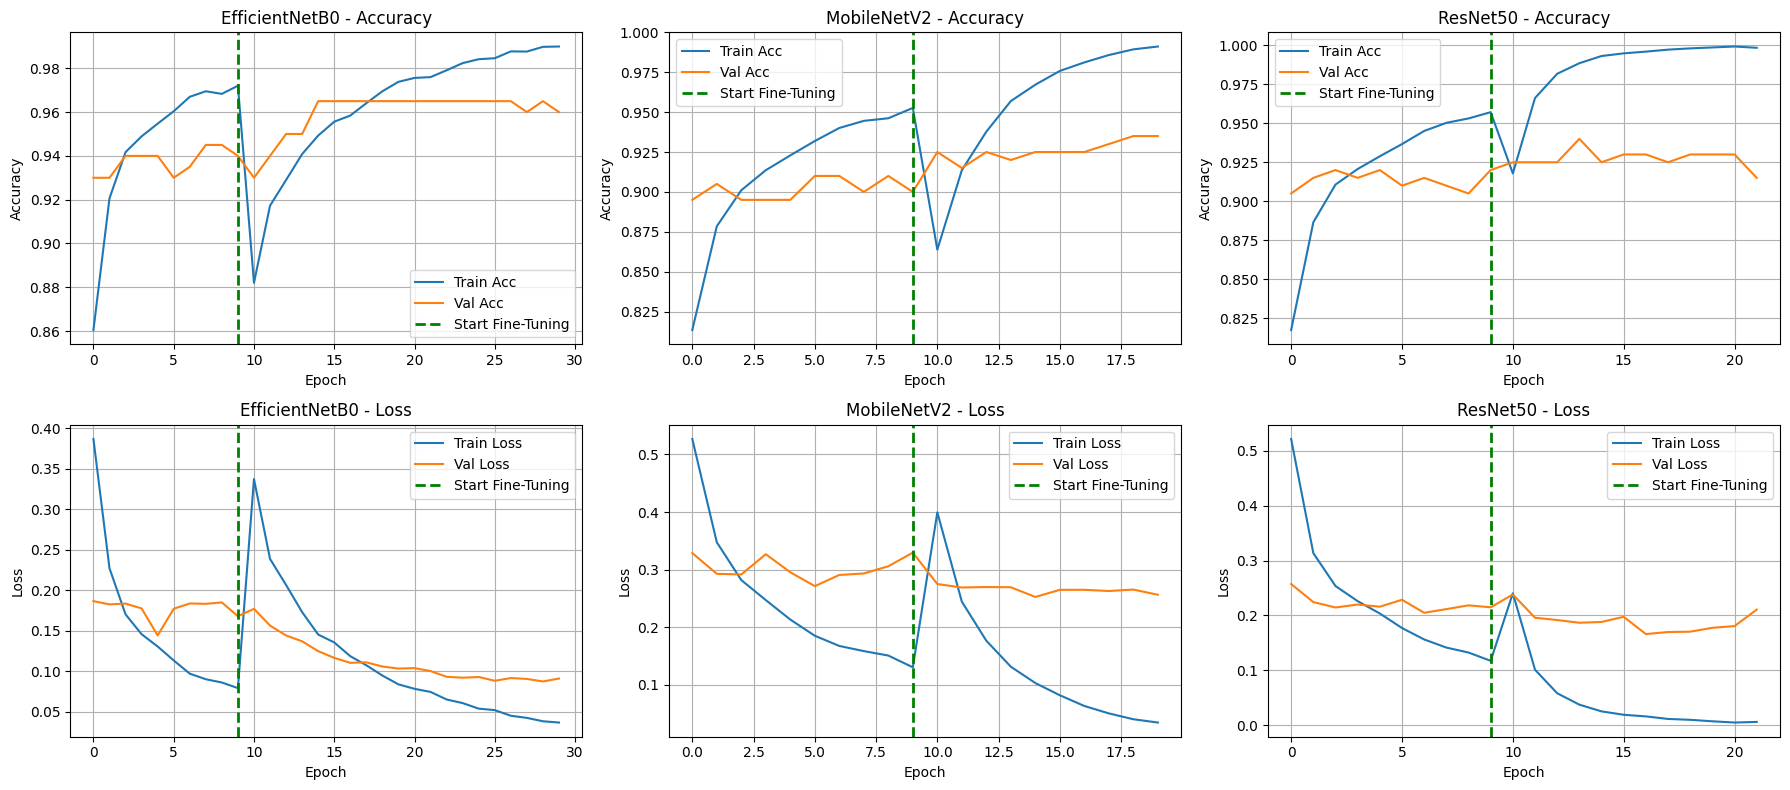

In [24]:
# dictionary jumlah epoch sebelum fine-tuning setiap model
ft_start_epochs = {
    "EfficientNetB0": len(history_efficient_stage1.history['loss'])-1,
    "MobileNetV2": len(history_mobilenet_stage1.history['loss'])-1,
    "ResNet50": len(history_resnet_stage1.history['loss'])-1
}

histories = [
    (combined_efficient, "EfficientNetB0"),
    (combined_mobilenet, "MobileNetV2"),
    (combined_resnet, "ResNet50")
]

fig, axs = plt.subplots(2, 3, figsize=(18, 8))

for col, (history, name) in enumerate(histories):

    ft_start = ft_start_epochs[name]

    # accuracy
    acc_line_train = axs[0, col].plot(history.history['accuracy'], label='Train Acc')
    acc_line_val   = axs[0, col].plot(history.history['val_accuracy'], label='Val Acc')

    # vertical line
    ft_line_acc = axs[0, col].axvline(ft_start, color='green', linestyle='--', linewidth=2,
                                      label='Start Fine-Tuning')

    axs[0, col].set_title(f'{name} - Accuracy')
    axs[0, col].set_xlabel('Epoch')
    axs[0, col].set_ylabel('Accuracy')
    axs[0, col].legend()
    axs[0, col].grid(True)

    # loss
    loss_line_train = axs[1, col].plot(history.history['loss'], label='Train Loss')
    loss_line_val   = axs[1, col].plot(history.history['val_loss'], label='Val Loss')

    # vertical line
    ft_line_loss = axs[1, col].axvline(ft_start, color='green', linestyle='--', linewidth=2,
                                       label='Start Fine-Tuning')

    axs[1, col].set_title(f'{name} - Loss')
    axs[1, col].set_xlabel('Epoch')
    axs[1, col].set_ylabel('Loss')
    axs[1, col].legend()
    axs[1, col].grid(True)

plt.tight_layout()
plt.show()
